In [12]:
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy import sin,pi
from numpy.random import rand, randn
from matplotlib import pyplot
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [13]:
def generate_latent_points(latent_dim, n):
        # 가우시안 분포로부터 데이터 벡터를 추출
        z_input = randn(latent_dim * n)
        # 네트워크에 입력할 배치 형태로 재구성
        z_input = z_input.reshape(n, latent_dim)
        return z_input

In [14]:
# 생성자 모델을 학습하는 레이어 구성
def define_generator(latent_dim, n_outputs= 2):
        model = Sequential()
#       model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
        model.add(Dense(15, activation='relu', input_dim=latent_dim))
        model.add(Dense(n_outputs, activation='linear'))
        return model

In [15]:
# 구별자 모델 학습 레이어 구성
def define_discriminator(n_inputs= 2):
        model = Sequential()
#       model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
        model.add(Dense(25, activation='relu', input_dim=n_inputs))
        model.add(Dense(1, activation='sigmoid'))
        #     compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

In [16]:
#       define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
        #     make weights in the discriminator not trainable
        discriminator.trainable = False
        #     connect them
        model = Sequential()
        # 아래 두 줄을 거치는 것이 D(G(z))의 결과와 같다
        #     add generator
        model.add(generator)
        #     add the discriminator
        model.add(discriminator) # D(G(z))
        #     compile model
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

In [17]:
# real samples, 트레이닝 데이터에 해당
def generate_real_samples(n):
        #     generate inputs in [-0.5, 0.5]*2.*pi
        p = (rand(n) - 0.5)*2.*pi
        #     generate outputs sin(x)
        q = sin(p)
        #     stack arrays
        p = p.reshape(n, 1)
        q = q.reshape(n, 1)
        x = hstack((p, q))
        #     generate class labels
        y = ones((n, 1))
        return x, y

In [18]:
#       use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
        #     generate points in latent space
        z_input = generate_latent_points(latent_dim, n)
        #     predict outputs
        x = generator.predict(z_input)
        #     create class labels
        y = zeros((n, 1))
        return x, y

In [24]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
        #     prepare real samples
        x_real, y_real = generate_real_samples(n)
        #     evaluate discriminator on real examples
        _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
        #     prepare fake examples
        x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
        #     evaluate discriminator on fake examples
        _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
        #     summarize discriminator performance
        print(epoch, acc_real, acc_fake)
        #     scatter plot real and fake data points
        pyplot.figure(figsize=(6,4))
        ax=pyplot.axes()
        ax.set_xlabel(r'$alpha$',fontsize=20)
        ax.set_ylabel(r'$beta$',fontsize=20)
#       ax.legend(fancybox=True, shadow=True, fontsize=15, framealpha=0.8)
        majorLocator= MultipleLocator(1)
        minorLocator= AutoMinorLocator()
        majorFormatter= FormatStrFormatter('%d')
        minorFormatter= FormatStrFormatter('%d')
        ax.xaxis.set_major_locator(majorLocator)
        ax.xaxis.set_major_formatter(majorFormatter)
        ax.xaxis.set_minor_locator(minorLocator)
        majorLocator= MultipleLocator(1)
        minorLocator= AutoMinorLocator()
        majorFormatter= FormatStrFormatter('%d')
        minorFormatter= FormatStrFormatter('%d')
        ax.yaxis.set_major_locator(majorLocator)
        ax.yaxis.set_major_formatter(majorFormatter)
        ax.yaxis.set_minor_locator(minorLocator)
        ax.tick_params(which='major', length=2, color='black')
        ax.tick_params(which='minor', length=4, color='brown')
        ax.set_facecolor("beige")
        pyplot.grid(True)
        pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red', s=5)
        pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue', s=5)
        pyplot.tight_layout()
        str1='sin'+str(epoch)+'.pdf'
        pyplot.savefig(str1,dpi=150)
#         pyplot.show()

In [25]:
#       train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=100000, n_batch=128, n_eval=100000):
        #    determine half the size of one batch, for updating the discriminator
        half_batch = int(n_batch / 2)
        #    manually enumerate epochs
        for i in range(n_epochs):
                #     prepare real samples
                x_real, y_real = generate_real_samples(half_batch)
                #     prepare fake examples
                x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
                #     update discriminator
                d_model.train_on_batch(x_real, y_real)
                d_model.train_on_batch(x_fake, y_fake)
                #     prepare points in latent space as input for the generator
                x_gan = generate_latent_points(latent_dim, n_batch)
                #     create inverted labels for the fake samples
                y_gan = ones((n_batch, 1))
                #     update the generator via the discriminator's error
                gan_model.train_on_batch(x_gan, y_gan)
                #     evaluate the model every n_eval epochs
                if (i+1) % n_eval == 0:
                        summarize_performance(i, g_model, d_model, latent_dim)

99999 0.63 0.5


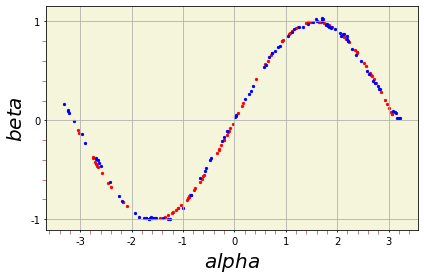

In [26]:
#     size of the latent space
latent_dim = 10
#     create the discriminator
discriminator = define_discriminator()
#     create the generator
generator = define_generator(latent_dim)
#     create the GAN
gan_model = define_gan(generator, discriminator)
#      train model
train(generator, discriminator, gan_model, latent_dim)